## 1. Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from keras.utils.np_utils import to_categorical

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


## 2. Import dataset and preprocessing

In [2]:
# import dataset from github
df = pd.read_csv('https://raw.githubusercontent.com/ifood/ifood-data-business-analyst-test/master/ml_project1_data.csv',
                 sep=',')
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,3,0,0,0,0,0,0,3,11,0


In [3]:
df = df.dropna()
df.groupby('Education').mean()['Income']

Education
2n Cycle      47633.190000
Basic         20306.259259
Graduation    52720.373656
Master        52917.534247
PhD           56145.313929
Name: Income, dtype: float64

### 2.1 Preprocessing

In [4]:
df_pp = df.copy()
# df['Education'].value_counts() # Basic (Lower), 2n Cycle, Master, PhD, Graduation (Higher) [5 categories]
# df['Marital_Status'].value_counts() # YOLO (Lower), Absurd,(Lower) Alone, Widow, Divorced, Single, Together, Married (Higher) [8 categories]

Notes:
was not clear if 2n Cycle was a type of graduation or high school. So, a analyze of Income of each category was made. Based on results, 2n Cycle corresponds to High school, not a pos-graduation

Reference of 2nCycle graduation:

In [5]:
from sklearn.preprocessing import OrdinalEncoder


# Categorizando coluna Education seguindo uma ordem de hierarquia crescente (Basic (0) -> PhD (4))

categories = [['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']]
ordinalEncoder = OrdinalEncoder(categories=categories)
df_pp['Education_Cat'] = ordinalEncoder.fit_transform(df_pp['Education'].values.reshape(-1, 1))
df_pp['Education_Cat'] = df_pp['Education_Cat'].astype(int)


In [6]:
# Categorizando coluna Marital Status utilizando get_dummies, já que a ordem das categorias não é importante
df_pp = pd.get_dummies(df_pp, columns=['Marital_Status'], prefix=['Marital_Type'])
df_pp['Marital_Status'] = df['Marital_Status']


## 3. Exploratory Analysis
Notes:
1. shape = (2240,29)
2. Income has NaN values
3. Categorical Ordinal features: Education
4. Categorical Nominal features: Martial_Status
5. Numerical data: All other features



### 3.2. Analyzing 10 samples (5 with target = 1 and 5 with target = 0)
Objective: find nice features and bad features. Maybe remove features to use better data

In [7]:
# df_plus_age = df_pp.copy()
# df_plus_age['Age'] = df_pp.apply(lambda x: 2014 - x['Year_Birth'], axis=1)
# samples = df_plus_age.sort_values(by=['Response'], ascending=False).groupby('Response').head(5)
# samples

Notes (Initial hypotheses):
- Columns correlated to Response: MntFruits,Meat,Fish,Hold; NumWebPurchases,CatalogPurchases; Education; Marital_Status
- Only 2 negative customers accepted the Campaign2
- None insight was found with positive customers related to older Campaigns

### 3.3 Lets see the statistics about data

In [8]:
df_pp.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Response,Education_Cat,Marital_Type_Absurd,Marital_Type_Alone,Marital_Type_Divorced,Marital_Type_Married,Marital_Type_Single,Marital_Type_Together,Marital_Type_Widow,Marital_Type_YOLO
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,5588.353339,1968.820397,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,...,0.150271,2.459838,0.000903,0.001354,0.104693,0.386733,0.212545,0.258574,0.034296,0.000903
std,3249.376275,11.985554,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,...,0.357417,1.004825,0.030035,0.036777,0.306227,0.487112,0.409201,0.437950,0.182030,0.030035
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2814.750000,1959.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8421.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,...,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Notes:


### 3.4 Lets see the balancement of the dataset

In [9]:
df_pp['Response'].value_counts()

0    1883
1     333
Name: Response, dtype: int64

Notes:
- The dataset is imbalanced
- Percentage of customers that responded to campaign: 15%
- Percentage of customers that not responded to campaign: 85%
- Therefore, the future model will be good to predict a customer that will not respond to a campaign and be bad to predict if customer will respond to campaign

### 3.4 Lets see the mean of each column based on label

In [10]:
df_3_4 = df_pp.groupby('Response').mean()
df_3_4

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Z_Revenue,Education_Cat,Marital_Type_Absurd,Marital_Type_Alone,Marital_Type_Divorced,Marital_Type_Married,Marital_Type_Single,Marital_Type_Together,Marital_Type_Widow,Marital_Type_YOLO
Response,,,,,,,,,,,,,,,,,,,,,
0,5617.712693,1968.701009,50839.132767,0.459373,0.540627,51.443972,270.160382,24.307488,144.577270,35.148168,...,11.0,2.417950,0.000531,0.001062,0.097716,0.403080,0.193840,0.272438,0.030802,0.000531
1,5422.336336,1969.495495,60209.675676,0.342342,0.306306,35.264264,502.615616,37.939940,293.765766,51.714715,...,11.0,2.696697,0.003003,0.003003,0.144144,0.294294,0.318318,0.180180,0.054054,0.003003


Notes:
- Year_Birth, **Income**, **Mnt.***,  Num.* - NumWebVisitsMonth, **AcceptedCmp[1-5]** was higher for **Response = 1**
- **Kidhome**, **Teenhome**, **Recency**, NumWebVisitsMonth, Complain was higher for **Response = 0**
- OBS: for the Num.* columns, NumWebPurchases, NumCatalogPurchases, NumStorePurchases have the most significant diff (>0.15)

## 4. Visualizations
Let's drop columns that does not give information


In [11]:
df_4 = df_pp.copy()
df_4 = df_4.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1)
df_4

,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Education_Cat,Marital_Type_Absurd,Marital_Type_Alone,Marital_Type_Divorced,Marital_Type_Married,Marital_Type_Single,Marital_Type_Together,Marital_Type_Widow,Marital_Type_YOLO,Marital_Status
0,1957,Graduation,58138.0,0,0,2012-09-04,58,635,88,546,...,2,0,0,0,0,1,0,0,0,Single
1,1954,Graduation,46344.0,1,1,2014-03-08,38,11,1,6,...,2,0,0,0,0,1,0,0,0,Single
2,1965,Graduation,71613.0,0,0,2013-08-21,26,426,49,127,...,2,0,0,0,0,0,1,0,0,Together
3,1984,Graduation,26646.0,1,0,2014-02-10,26,11,4,20,...,2,0,0,0,0,0,1,0,0,Together
4,1981,PhD,58293.0,1,0,2014-01-19,94,173,43,118,...,4,0,0,0,1,0,0,0,0,Married
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967,Graduation,61223.0,0,1,2013-06-13,46,709,43,182,...,2,0,0,0,1,0,0,0,0,Married
2236,1946,PhD,64014.0,2,1,2014-06-10,56,406,0,30,...,4,0,0,0,0,0,1,0,0,Together
2237,1981,Graduation,56981.0,0,0,2014-01-25,91,908,48,217,...,2,0,0,1,0,0,0,0,0,Divorced
2238,1956,Master,69245.0,0,1,2014-01-24,8,428,30,214,...,3,0,0,0,0,0,1,0,0,Together


### 4.1 Univariate Plot

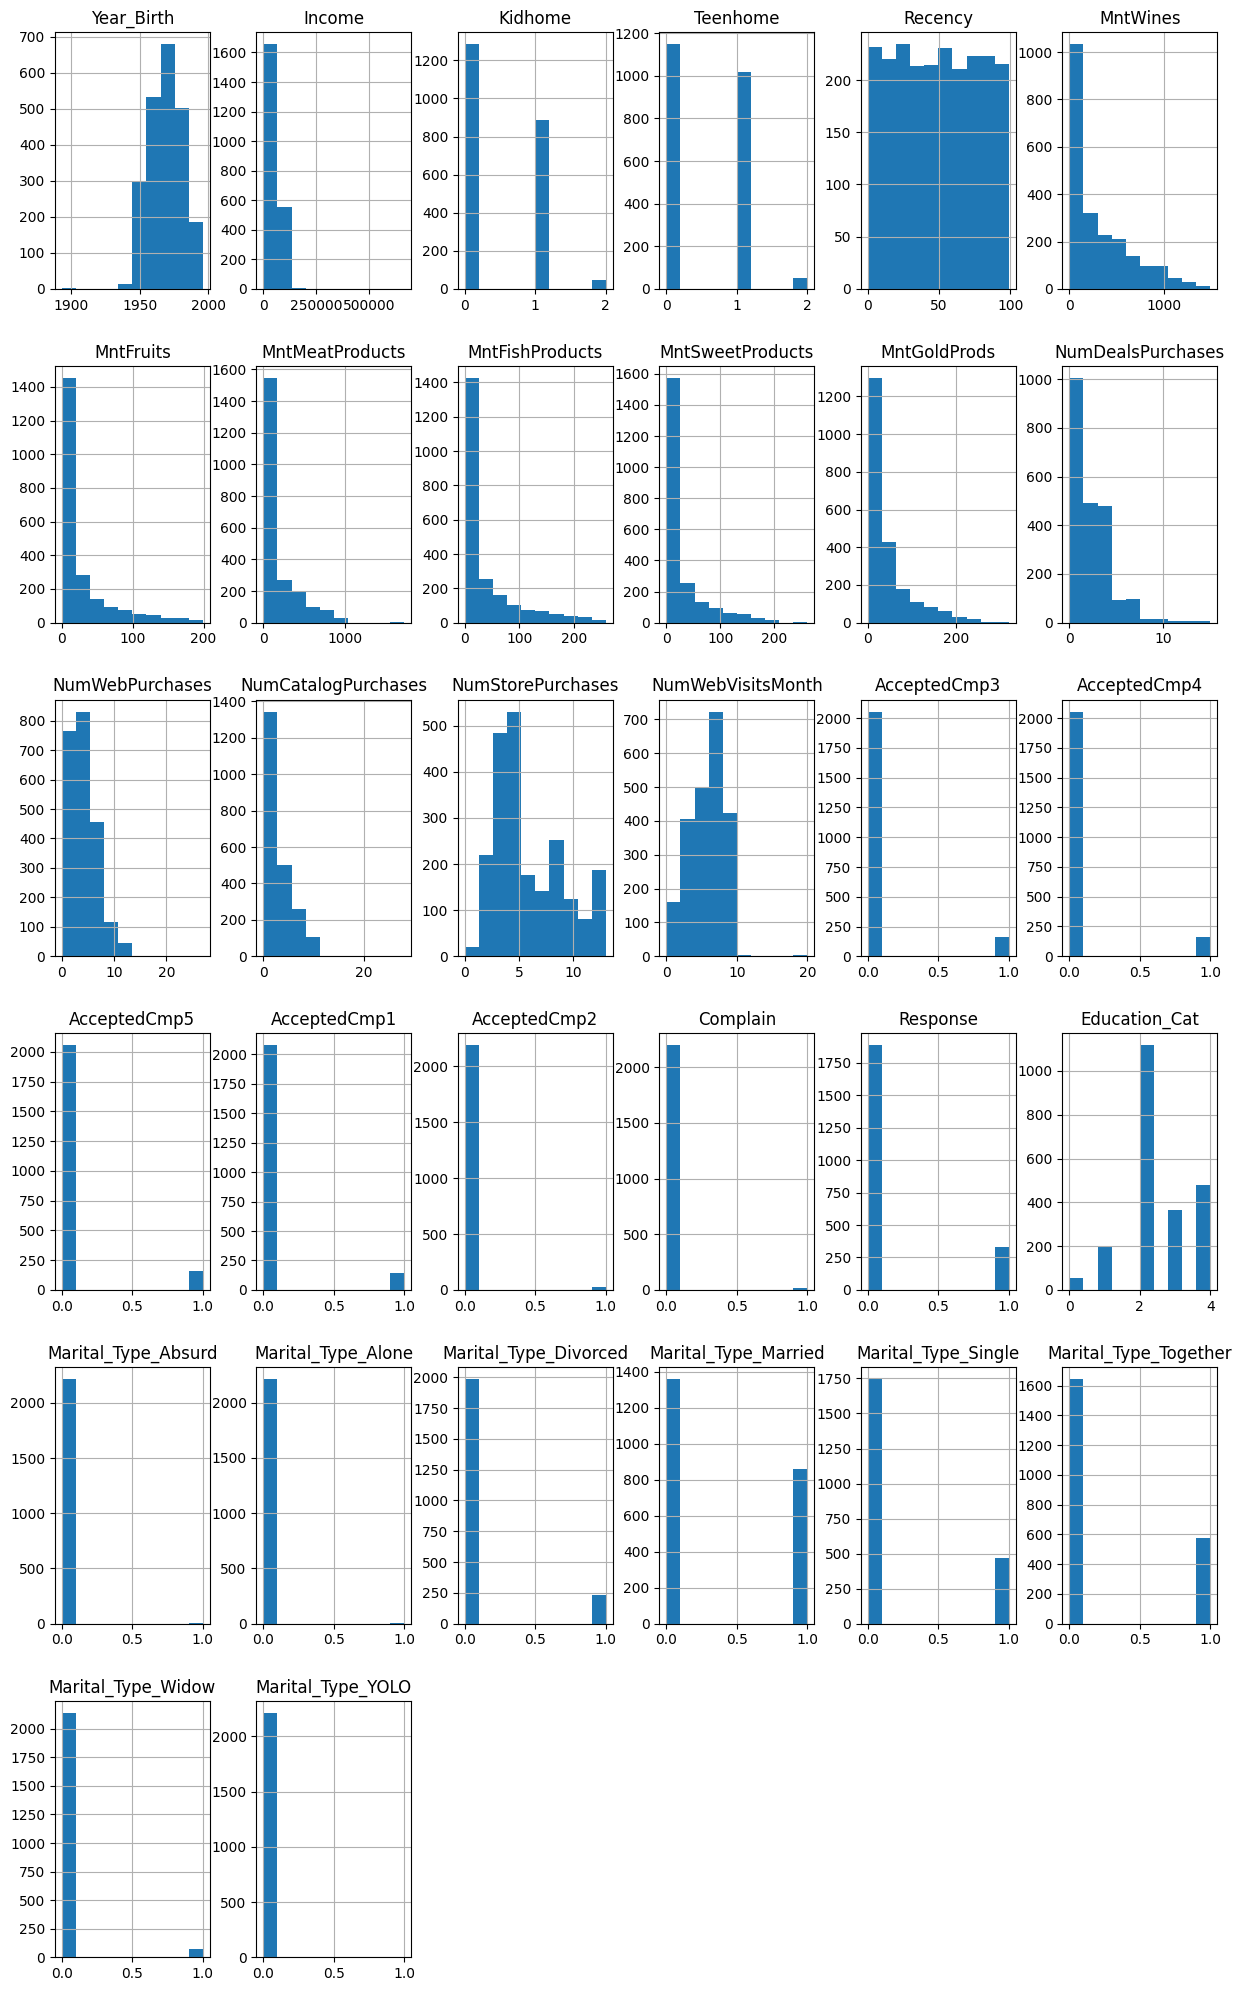

In [12]:
df_4.hist(figsize=(15, 25))
plt.show()

### 4.2 Multivariate Plot


Notes:
- Year_Birth, **Income**, **Mnt.***,  Num.* - NumWebVisitsMonth, **AcceptedCmp[1-5]** was higher for **Response = 1**
- **Kidhome**, **Teenhome**, **Recency**, NumWebVisitsMonth, Complain was higher for **Response = 0**
- OBS: for the Num.* columns, NumWebPurchases, NumCatalogPurchases, NumStorePurchases have the most significant diff (>0.15)

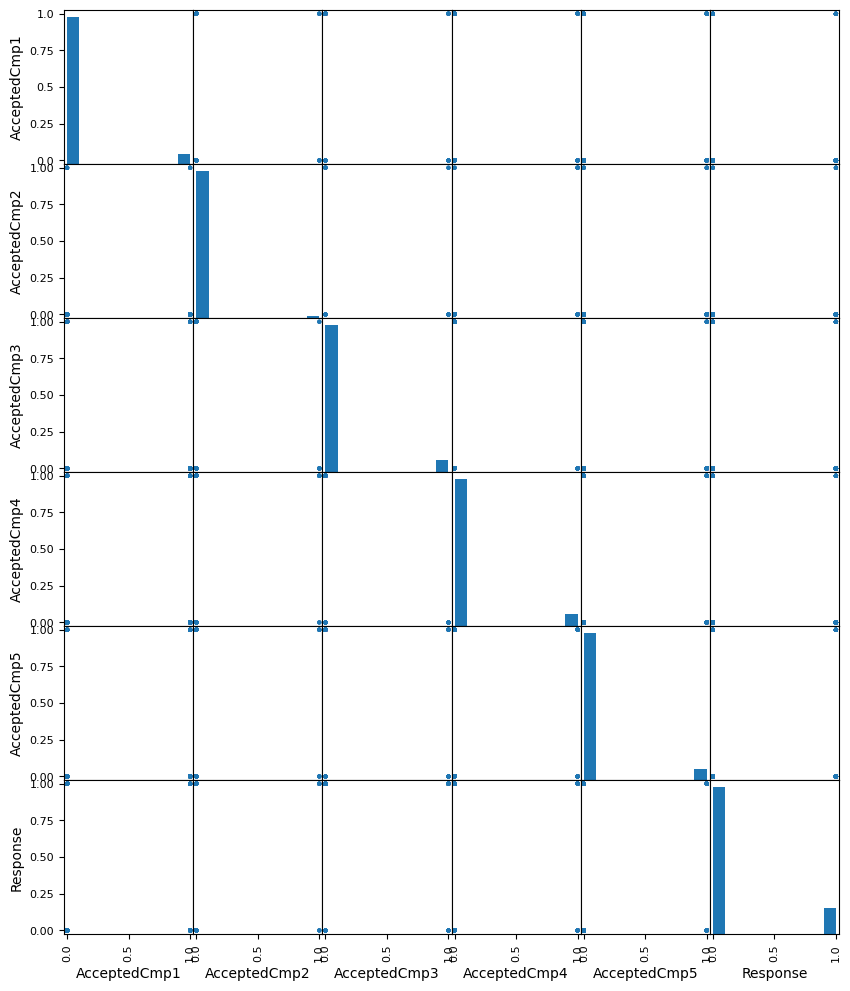

In [13]:

df_4_2 = df_4.copy()
df_4_2 = df_4_2.loc[:, ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]
scatter_matrix(df_4_2, figsize=(10, 12))
plt.show()

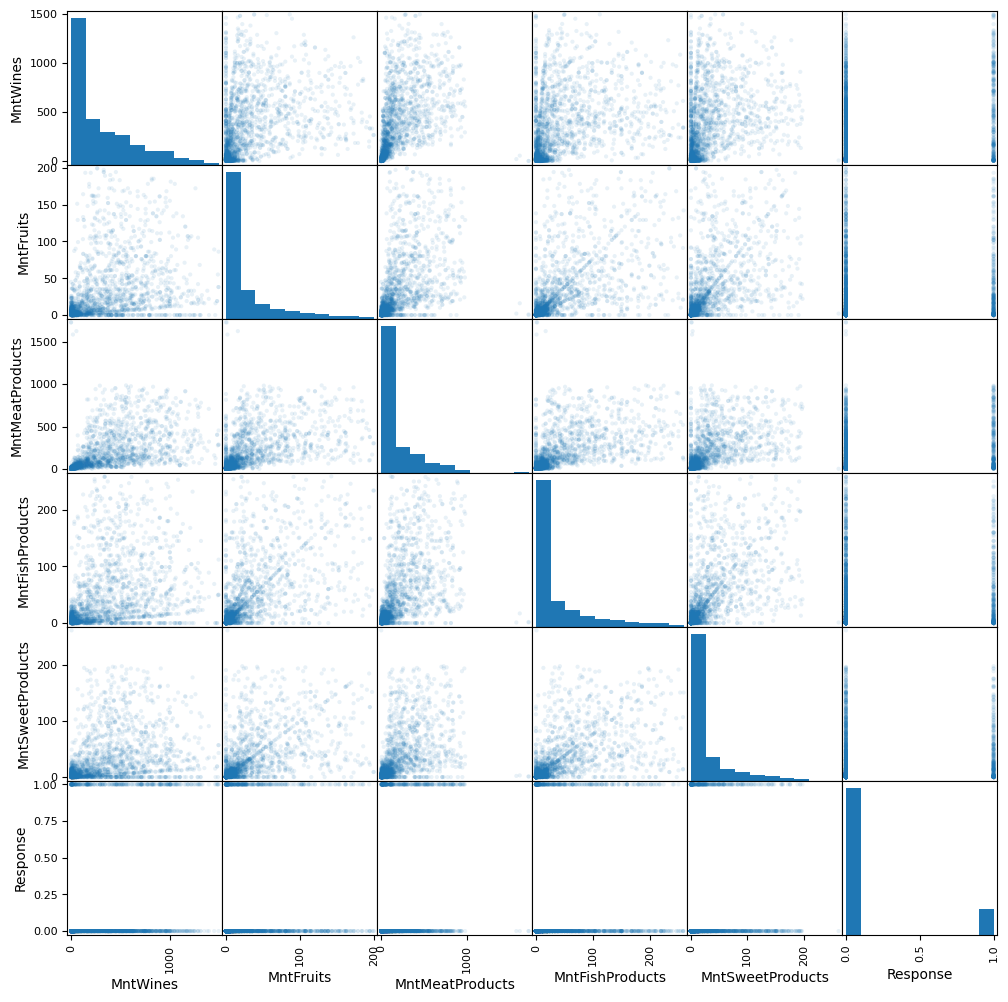

In [14]:

df_4_2 = df_4.copy()
df_4_2 = df_4_2.loc[:, ['MntWines', 'MntFruits',
                        'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'Response']]
scatter_matrix(df_4_2, figsize=(12, 12),alpha=0.1)
plt.show()

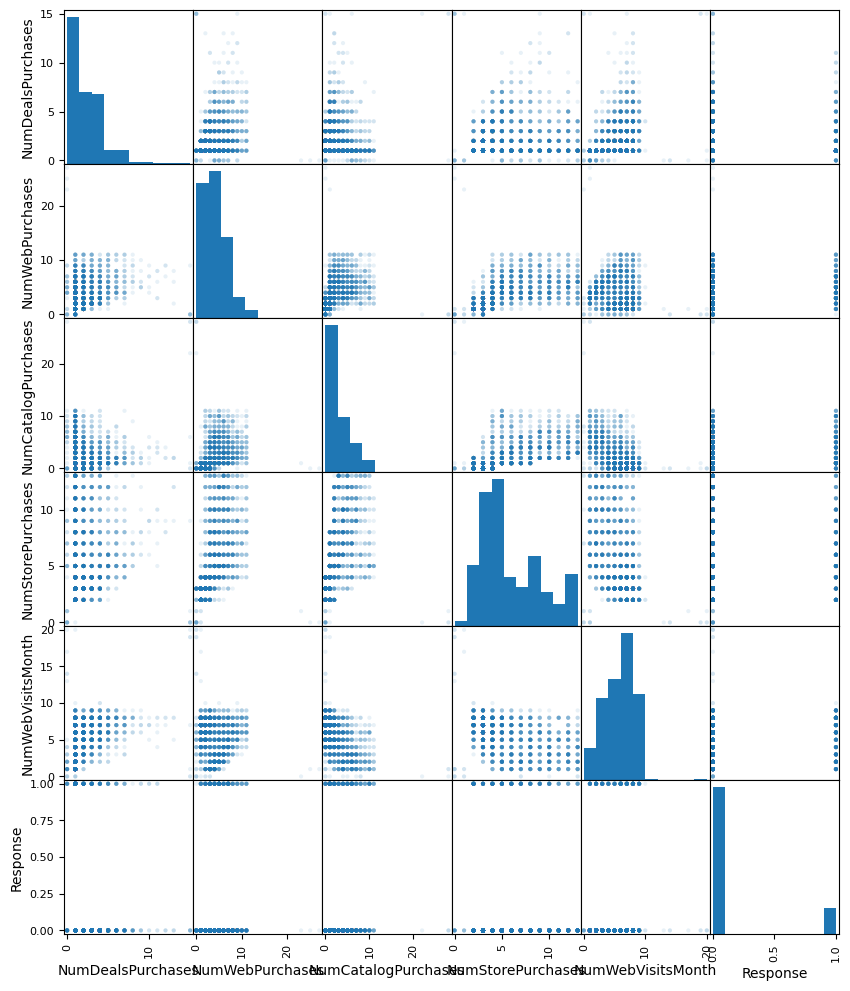

In [15]:

df_4_2 = df_4.copy()
df_4_2 = df_4_2.loc[:, ['NumDealsPurchases', 'NumWebPurchases',
                        'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Response']]
scatter_matrix(df_4_2, figsize=(10, 12),alpha=0.1)
plt.show()

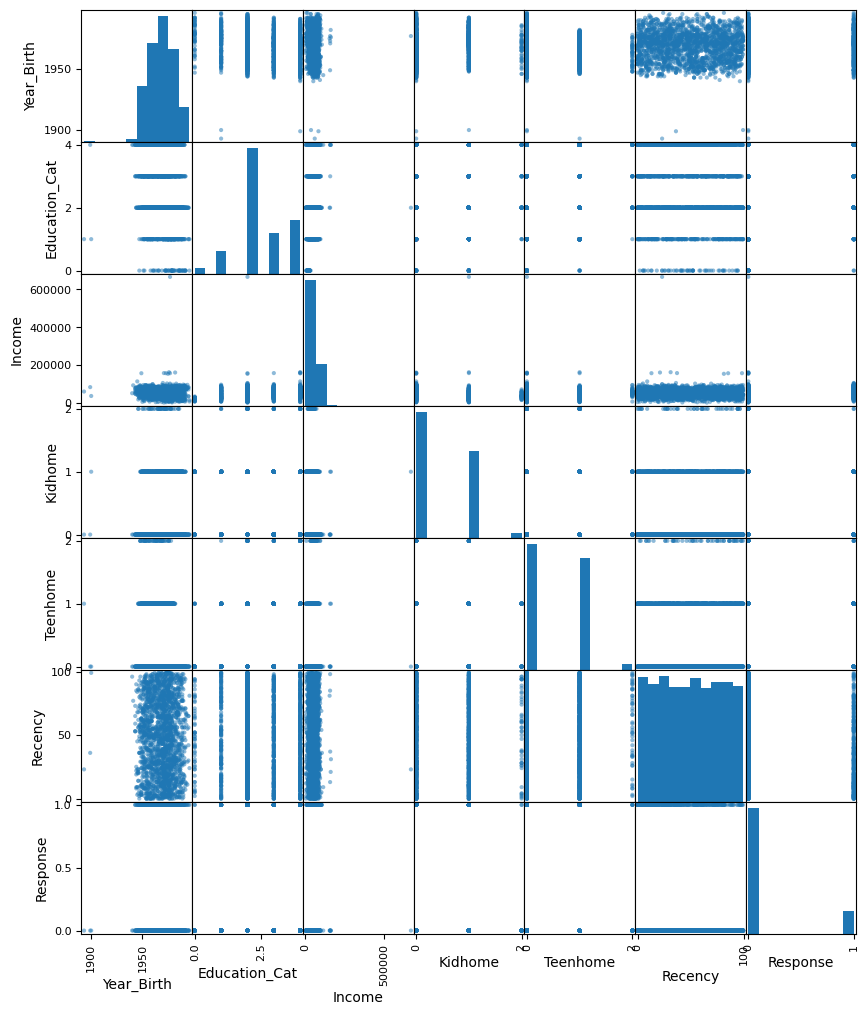

In [16]:

df_4_2 = df_4.copy()
df_4_2 = df_4_2.loc[:, ['Year_Birth', 'Education_Cat', 'Income', 'Kidhome',
                        'Teenhome', 'Dt_Customer', 'Recency', 'Response']]
scatter_matrix(df_4_2, figsize=(10, 12))
plt.show()

Notes:
- Can be said that Higher Wine and Meet, higher the chance that is a positive costumer
- Can be said that higher fish, higher fruits and wine
- Can be said that higher wine, higher meat and sweets
- Can be said that lower the store purchases, higher the chance that is a negative costumer

### 4.3 Confirming notes above using corr()

In [17]:
corr = df_pp.corr()
corr

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Response,Education_Cat,Marital_Type_Absurd,Marital_Type_Alone,Marital_Type_Divorced,Marital_Type_Married,Marital_Type_Single,Marital_Type_Together,Marital_Type_Widow,Marital_Type_YOLO
ID,1.000000,0.002355,0.013095,0.001736,-0.003030,-0.044376,-0.021084,0.007326,-0.005902,-0.023992,...,-0.021491,-0.003574,0.004285,-0.032414,-0.016978,0.011160,-0.015886,0.007168,0.022663,0.002074
Year_Birth,0.002355,1.000000,-0.161791,0.233615,-0.350791,-0.016295,-0.159451,-0.017747,-0.033697,-0.040425,...,0.023692,-0.184809,0.015500,0.012842,-0.072614,0.049561,0.119262,-0.052903,-0.158168,0.010483
Income,0.013095,-0.161791,1.000000,-0.428669,0.019133,-0.003970,0.578650,0.430842,0.584633,0.438871,...,0.133047,0.149338,0.024026,-0.012374,0.007975,-0.016479,-0.025843,0.023425,0.031706,-0.004556
Kidhome,0.001736,0.233615,-0.428669,1.000000,-0.039869,0.011492,-0.497336,-0.373396,-0.439261,-0.388884,...,-0.077909,-0.053710,-0.024737,0.038289,-0.017834,0.017933,0.014217,0.009324,-0.071952,-0.024737
Teenhome,-0.003030,-0.350791,0.019133,-0.039869,1.000000,0.013838,0.003747,-0.176558,-0.261122,-0.205242,...,-0.153901,0.137042,-0.027921,0.010913,0.053489,0.008276,-0.099447,0.025379,0.048258,0.027323
Recency,-0.044376,-0.016295,-0.003970,0.011492,0.013838,1.000000,0.015721,-0.005844,0.022518,0.000551,...,-0.199766,-0.013858,0.004141,-0.023763,0.005606,-0.019268,0.003356,0.019933,-0.001367,-0.047783
MntWines,-0.021084,-0.159451,0.578650,-0.497336,0.003747,0.015721,1.000000,0.387024,0.568860,0.397721,...,0.246299,0.215037,0.004492,-0.013147,0.020029,-0.012330,-0.021198,0.005799,0.034667,0.001507
MntFruits,0.007326,-0.017747,0.430842,-0.373396,-0.176558,-0.005844,0.387024,1.000000,0.547822,0.593431,...,0.122443,-0.076176,0.043925,-0.020689,0.009203,-0.014117,0.011819,-0.012694,0.026111,-0.017644
MntMeatProducts,-0.005902,-0.033697,0.584633,-0.439261,-0.261122,0.022518,0.568860,0.547822,1.000000,0.573574,...,0.237746,0.048746,0.019503,-0.023097,-0.025604,-0.021602,0.041365,-0.001446,0.015408,-0.015682
MntFishProducts,-0.023992,-0.040425,0.438871,-0.388884,-0.205242,0.000551,0.397721,0.593431,0.573574,1.000000,...,0.108145,-0.102180,0.092167,-0.020159,-0.016208,-0.031493,0.010774,0.015375,0.042243,-0.018469


TODO:
1. Ver quais são as features mais correlacionadas ao Response
2. Ver quais features são mais correlacionadas as features que são correlacionadas ao Response

## 5. Evaluate Models

### Metodology 1
#### Use features more correlated with target Response for training

Get column names more correlated to Response (abs >= 0.1)

In [37]:
df_more_corr = corr.loc[abs(corr['Response']) >= 0.09]
columns_more_corr = df_more_corr.index.tolist()

In [19]:
df_m1 = df_pp[columns_more_corr]

In [20]:
df_columns = [col for col in df_m1.columns if col != 'Response']
df_columns.insert(len(df_m1), 'Response')
df_m1 = df_m1[df_columns]
...

Ellipsis

In [43]:
from sklearn.preprocessing import StandardScaler

m1_array = df_m1.values
X = m1_array[:, :-1]
y = m1_array[:, -1]



In [44]:
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
X = ss.fit_transform(X)

Notes:
Was decided to use the MinMaxScaler normalization because the models had of 2% increase of accuracy in comparison to not using any kind of normalization

This normnaization maps each column to a range of 0 to 1, based on the max value of the columns and the minimum value of the column to decide the final value

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=2)
...

Ellipsis

In [46]:
from sklearn import model_selection

models = []

models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC(gamma='auto')))
results = []
names = []
for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: Mean Accuracy={cv_results.mean():.5f}, Standard Deviation={cv_results.std():.5f}")


LR: Mean Accuracy=0.87865, Standard Deviation=0.01179
KNN: Mean Accuracy=0.86286, Standard Deviation=0.01756
CART: Mean Accuracy=0.82225, Standard Deviation=0.02581
SVM: Mean Accuracy=0.86906, Standard Deviation=0.01048


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=2)

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_lr = LogisticRegression(solver='liblinear', multi_class='ovr')
model_lr.fit(X_train,y_train)
predictions = model_lr.predict(X_test)

print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0.8806306306306306
[[367   9]
 [ 44  24]]
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93       376
         1.0       0.73      0.35      0.48        68

    accuracy                           0.88       444
   macro avg       0.81      0.66      0.70       444
weighted avg       0.87      0.88      0.86       444



In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# model_svm = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
model_svm = SVC(gamma='auto')
model_svm.fit(X_train,y_train)
predictions = model_svm.predict(X_test)

print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0.8693693693693694
[[373   3]
 [ 55  13]]
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       376
         1.0       0.81      0.19      0.31        68

    accuracy                           0.87       444
   macro avg       0.84      0.59      0.62       444
weighted avg       0.86      0.87      0.83       444



Notes:
LR and SVM were the best models for StratifiedKfold and 0.8 of train_size, with 0.862 and 0.850 of accuracy, respectively

### Metodology 2
#### Use all features for training

In [31]:
df_m2 = df_pp.copy()
df_m2.drop(columns=['Education', 'Marital_Status','Dt_Customer','Z_Revenue','Z_CostContact'], inplace=True)


In [32]:
df_columns = [col for col in df_m2.columns if col != 'Response']
df_columns.insert(len(df_m2), 'Response')
df_m2 = df_m2[df_columns]


In [33]:
m2_array = df_m2.values
X = m2_array[:, :-1]
y = m2_array[:, -1]

In [34]:
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
X = ss.fit_transform(X)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=2)
...

In [38]:
from sklearn import model_selection

models = []

models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC(gamma='auto')))
results = []
names = []
for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: Mean Accuracy={cv_results.mean():.5f}, Standard Deviation={cv_results.std():.5f}")


LR: Mean Accuracy=0.87864, Standard Deviation=0.01805
KNN: Mean Accuracy=0.86733, Standard Deviation=0.02787
CART: Mean Accuracy=0.83637, Standard Deviation=0.02821
SVM: Mean Accuracy=0.86963, Standard Deviation=0.01006


Notes:
LR and SVM were the best models here too. Using StratifiedKfold and 80/20 train_test_split, with 0.862 and 0.850 of accuracy, respectively

### 6. Making predictions using the winner models LR and SVM

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=2)
...

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_lr = LogisticRegression(solver='liblinear', multi_class='ovr')
model_lr.fit(X_train,y_train)
predictions = model_lr.predict(X_test)

print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0.881203007518797
[[547  15]
 [ 64  39]]
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93       562
         1.0       0.72      0.38      0.50       103

    accuracy                           0.88       665
   macro avg       0.81      0.68      0.71       665
weighted avg       0.87      0.88      0.87       665



In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_svm = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
model_svm.fit(X_train,y_train)
predictions = model_svm.predict(X_test)

print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0.8676691729323308
[[550  12]
 [ 76  27]]
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       562
         1.0       0.69      0.26      0.38       103

    accuracy                           0.87       665
   macro avg       0.79      0.62      0.65       665
weighted avg       0.85      0.87      0.84       665



In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# model_svm = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
model_svm = SVC(gamma='auto')
model_svm.fit(X_train,y_train)
predictions = model_svm.predict(X_test)

print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0.8676691729323308
[[555   7]
 [ 81  22]]
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       562
         1.0       0.76      0.21      0.33       103

    accuracy                           0.87       665
   macro avg       0.82      0.60      0.63       665
weighted avg       0.85      0.87      0.83       665

